# Jores et al 2021 Plotting 
**Authorship:**
Adam Klie, *09/12/2022*
***
**Description:**
Notebook to generate plots for the Jores et al (2021) dataset that are not included in the other notebooks.
 - Summary table of benchmarking results for for each model type
 - Cleaner seq track plots for top sequences
 - TomTom filter annotation analysis
 - Loss and metric plots
***

In [93]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

In [131]:
# General imports
import os
import glob
import torch
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# EUGENe imports and settings
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/fix_full/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/fix_full/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/fix_full/jores21"

# EUGENe packages
import seqdata as sd

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Generate performance figures

## Leaf models

In [135]:
# Read in the predictions 
leaf_predictions = pd.read_csv(os.path.join(settings.output_dir, "leaf", "jores21_leaf_test_predictions.tsv"), sep="\t", index_col=0)
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "jores21_leaf_test_predictions.zarr"))
sdata_leaf.load()

<xarray.Dataset>
Dimensions:                         (_sequence: 7154, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables: (12/20)
    batch                           <U4 'leaf'
    cnn_leaf_trial_1_preds          (_sequence) float32 0.4961 3.964 ... -1.584
    cnn_leaf_trial_2_preds          (_sequence) float32 0.2577 3.618 ... -0.9981
    cnn_leaf_trial_3_preds          (_sequence) float32 0.6277 3.511 ... -1.039
    deepstarr_leaf_trial_1_preds    (_sequence) float32 0.1336 3.693 ... -1.989
    deepstarr_leaf_trial_2_preds    (_sequence) float32 0.6769 3.165 ... -2.036
    ...                              ...
    jores21_cnn_leaf_trial_2_preds  (_sequence) float32 0.5678 2.725 ... -2.125
    jores21_cnn_leaf_trial_3_preds  (_sequence) float32 0.1956 3.349 ... -2.636
    ohe_seq                         (_sequence, length, _ohe) uint8 0 0 ... 0 0
    seq                             (_sequence) <U1 'T' 'G' 'C' ... 'C' 'C' 'G'
    set                             (_sequence) <U1 't' 't' 't' ... 't' 't' 't'
    sp                              (_sequence) <U1 'A' 'S' 'Z' ... 'Z' 'S' 'Z'
Attributes:
    max_jitter:  0

In [136]:
# Get only variables with "preds"
preds_keys = sdata_leaf.data_vars.keys()

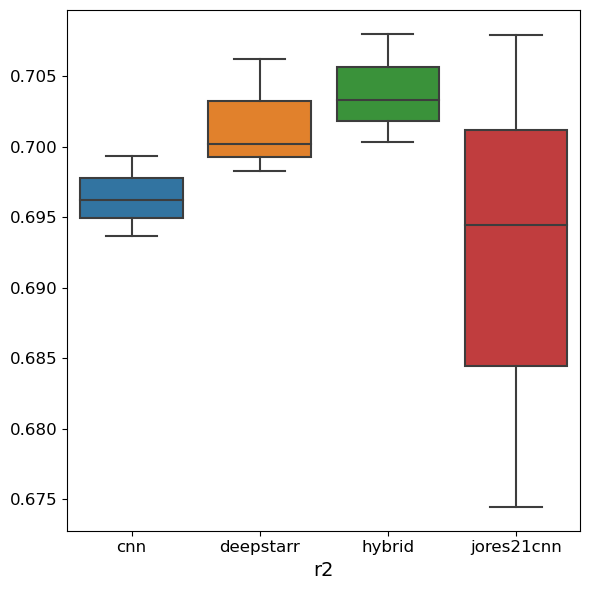

In [137]:
# Summarize performance across models for r2
leaf_model_scores = pl.performance_summary(
    sdata_leaf,
    target_key="enrichment",
    prediction_groups=["cnn"]*3 + ["deepstarr"]*3 + ["hybrid"]*3 + ["jores21cnn"]*3,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "leaf_performance_boxplot.pdf")
)

In [138]:
leaf_model_scores

,r2,prediction_groups
cnn_leaf_trial_1_preds,0.693677,cnn
cnn_leaf_trial_2_preds,0.696240,cnn
cnn_leaf_trial_3_preds,0.699349,cnn
deepstarr_leaf_trial_1_preds,0.698277,deepstarr
deepstarr_leaf_trial_2_preds,0.700219,deepstarr
deepstarr_leaf_trial_3_preds,0.706244,deepstarr
hybrid_leaf_trial_1_preds,0.700316,hybrid
hybrid_leaf_trial_2_preds,0.703296,hybrid
hybrid_leaf_trial_3_preds,0.708041,hybrid
jores21_cnn_leaf_trial_1_preds,0.707914,jores21cnn


In [139]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = leaf_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([False, False, False, False, False, False]),
 array([0.6 , 0.6 , 1.  , 0.84, 0.6 , 0.6 ]),
 0.008512444610847103,
 0.008333333333333333)

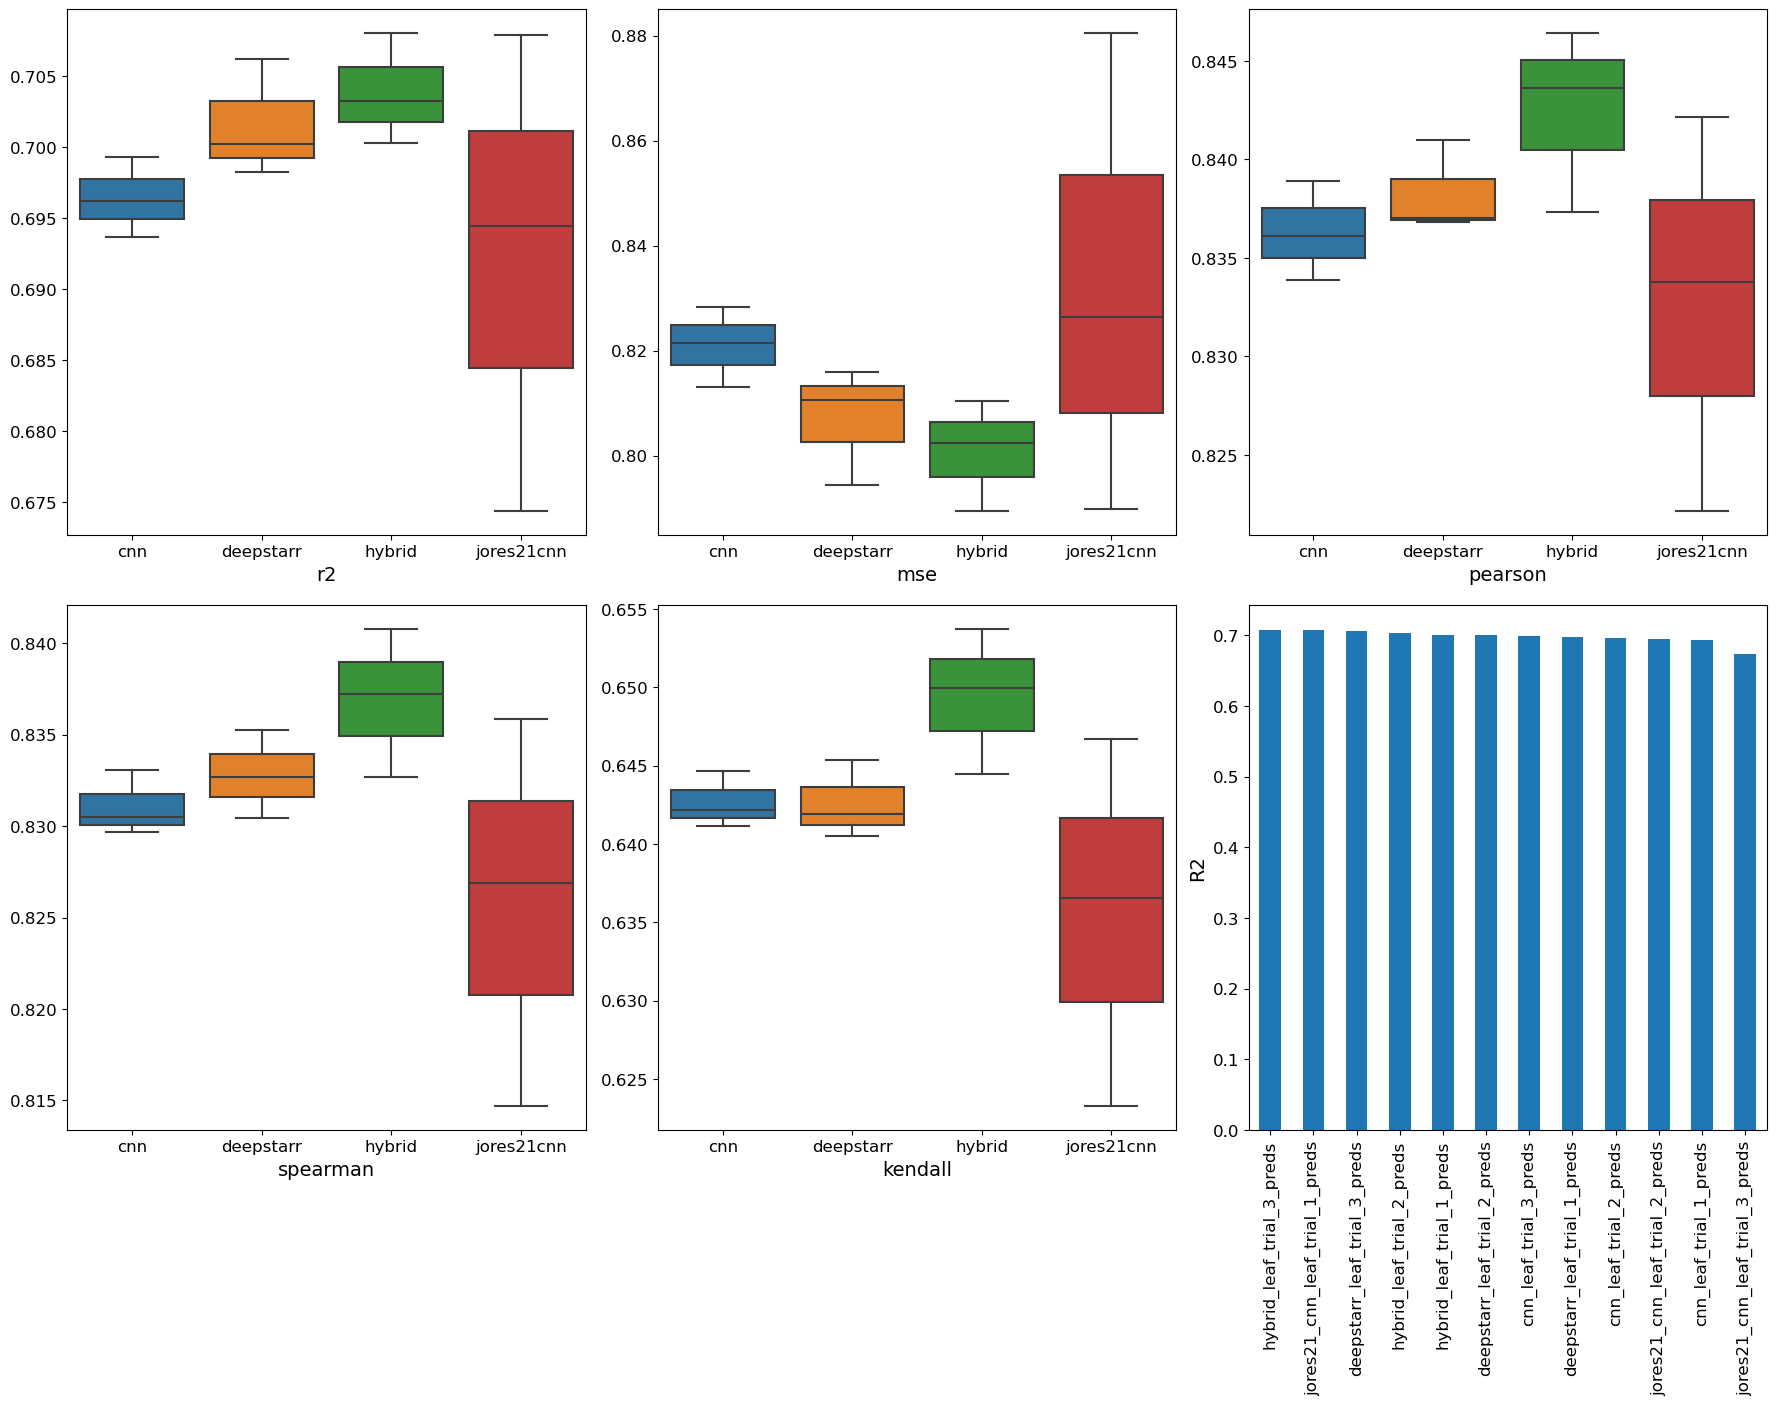

In [126]:
# Summarize performance across models for multiple metrics
leaf_model_scores = pl.performance_summary(
    sdata_leaf,
    target_key="enrichment",
    prediction_groups=["cnn"]*3 + ["deepstarr"]*3 + ["hybrid"]*3 + ["jores21cnn"]*3,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = leaf_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "leaf_performance_summary.pdf"))

In [127]:
# Save the performance summary as a table
leaf_model_scores.to_csv(os.path.join(settings.output_dir, "leaf_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
A 0.5198274025295448 0.6688013488830524 0.7111663624297035
S 0.6691998943715975 0.8981282089688057 0.839550559273431
Z 0.747735605846671 0.7681063888838408 0.8663183366479608


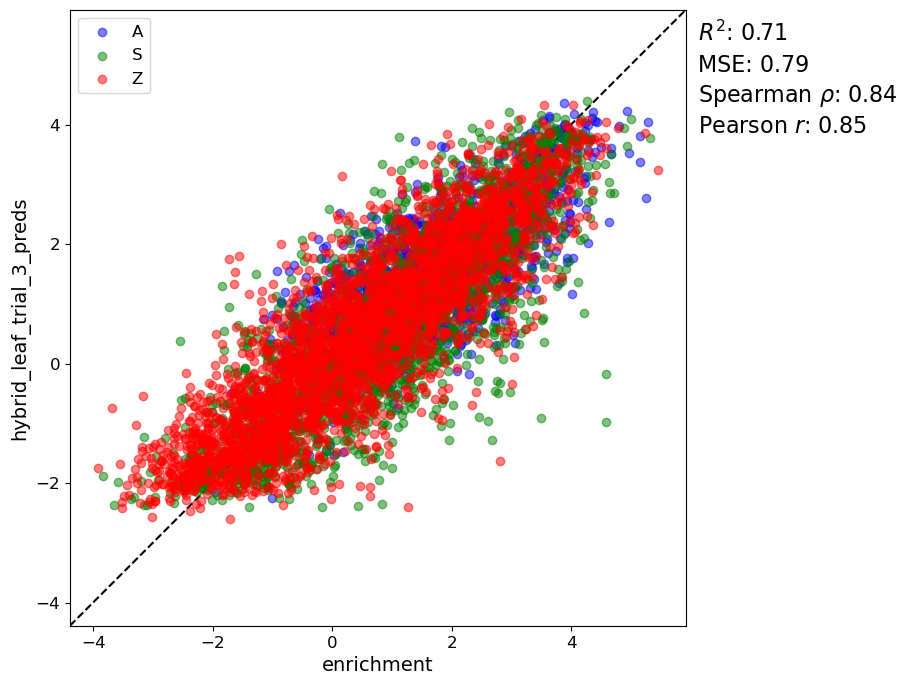

In [128]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_leaf, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "leaf_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


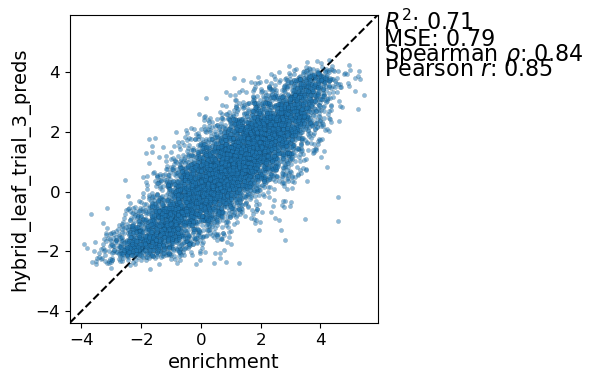

In [129]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_leaf, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "leaf_best_model_performance_scatter.pdf")
)

## Proto models

In [132]:
# Read in the predictions 
proto_predictions = pd.read_csv(os.path.join(settings.output_dir, "proto", "jores21_proto_test_predictions.tsv"), sep="\t", index_col=0)
sdata_proto = sd.open_zarr(os.path.join(settings.output_dir, "proto", "jores21_proto_test_predictions.zarr"))
sdata_proto.load()

<xarray.Dataset>
Dimensions:                          (_sequence: 7595, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables: (12/20)
    batch                            <U5 'proto'
    cnn_proto_trial_1_preds          (_sequence) float32 0.9998 ... -1.163
    cnn_proto_trial_2_preds          (_sequence) float32 0.7619 ... -1.392
    cnn_proto_trial_3_preds          (_sequence) float32 0.9144 ... -1.532
    deepstarr_proto_trial_1_preds    (_sequence) float32 0.6637 0.8193 ... -0.74
    deepstarr_proto_trial_2_preds    (_sequence) float32 1.081 0.6507 ... -1.194
    ...                               ...
    jores21_cnn_proto_trial_2_preds  (_sequence) float32 1.353 0.4959 ... -1.13
    jores21_cnn_proto_trial_3_preds  (_sequence) float32 0.51 0.1983 ... -1.194
    ohe_seq                          (_sequence, length, _ohe) uint8 0 1 ... 0 1
    seq                              (_sequence) <U1 'C' 'T' 'G' ... 'A' 'T' 'C'
    set                              (_sequence) <U1 't' 't' 't' ... 't' 't' 't'
    sp                               (_sequence) <U1 'Z' 'S' 'Z' ... 'Z' 'S' 'S'
Attributes:
    max_jitter:  0

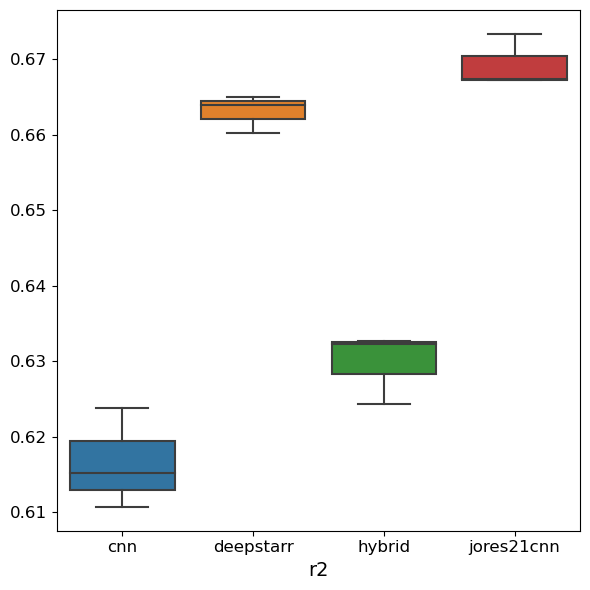

In [134]:
# Summarize performance across models for r2
proto_model_scores = pl.performance_summary(
    sdata_proto,
    target_key="enrichment",
    prediction_groups=["cnn"]*3 + ["deepstarr"]*3 + ["hybrid"]*3 + ["jores21cnn"]*3,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "proto_performance_boxplot.pdf")
)

In [19]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = proto_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([ True, False,  True, False,  True,  True]),
 array([0.01190476, 0.26666667, 0.01190476, 0.30952381, 0.01190476,
        0.01190476]),
 0.008512444610847103,
 0.008333333333333333)

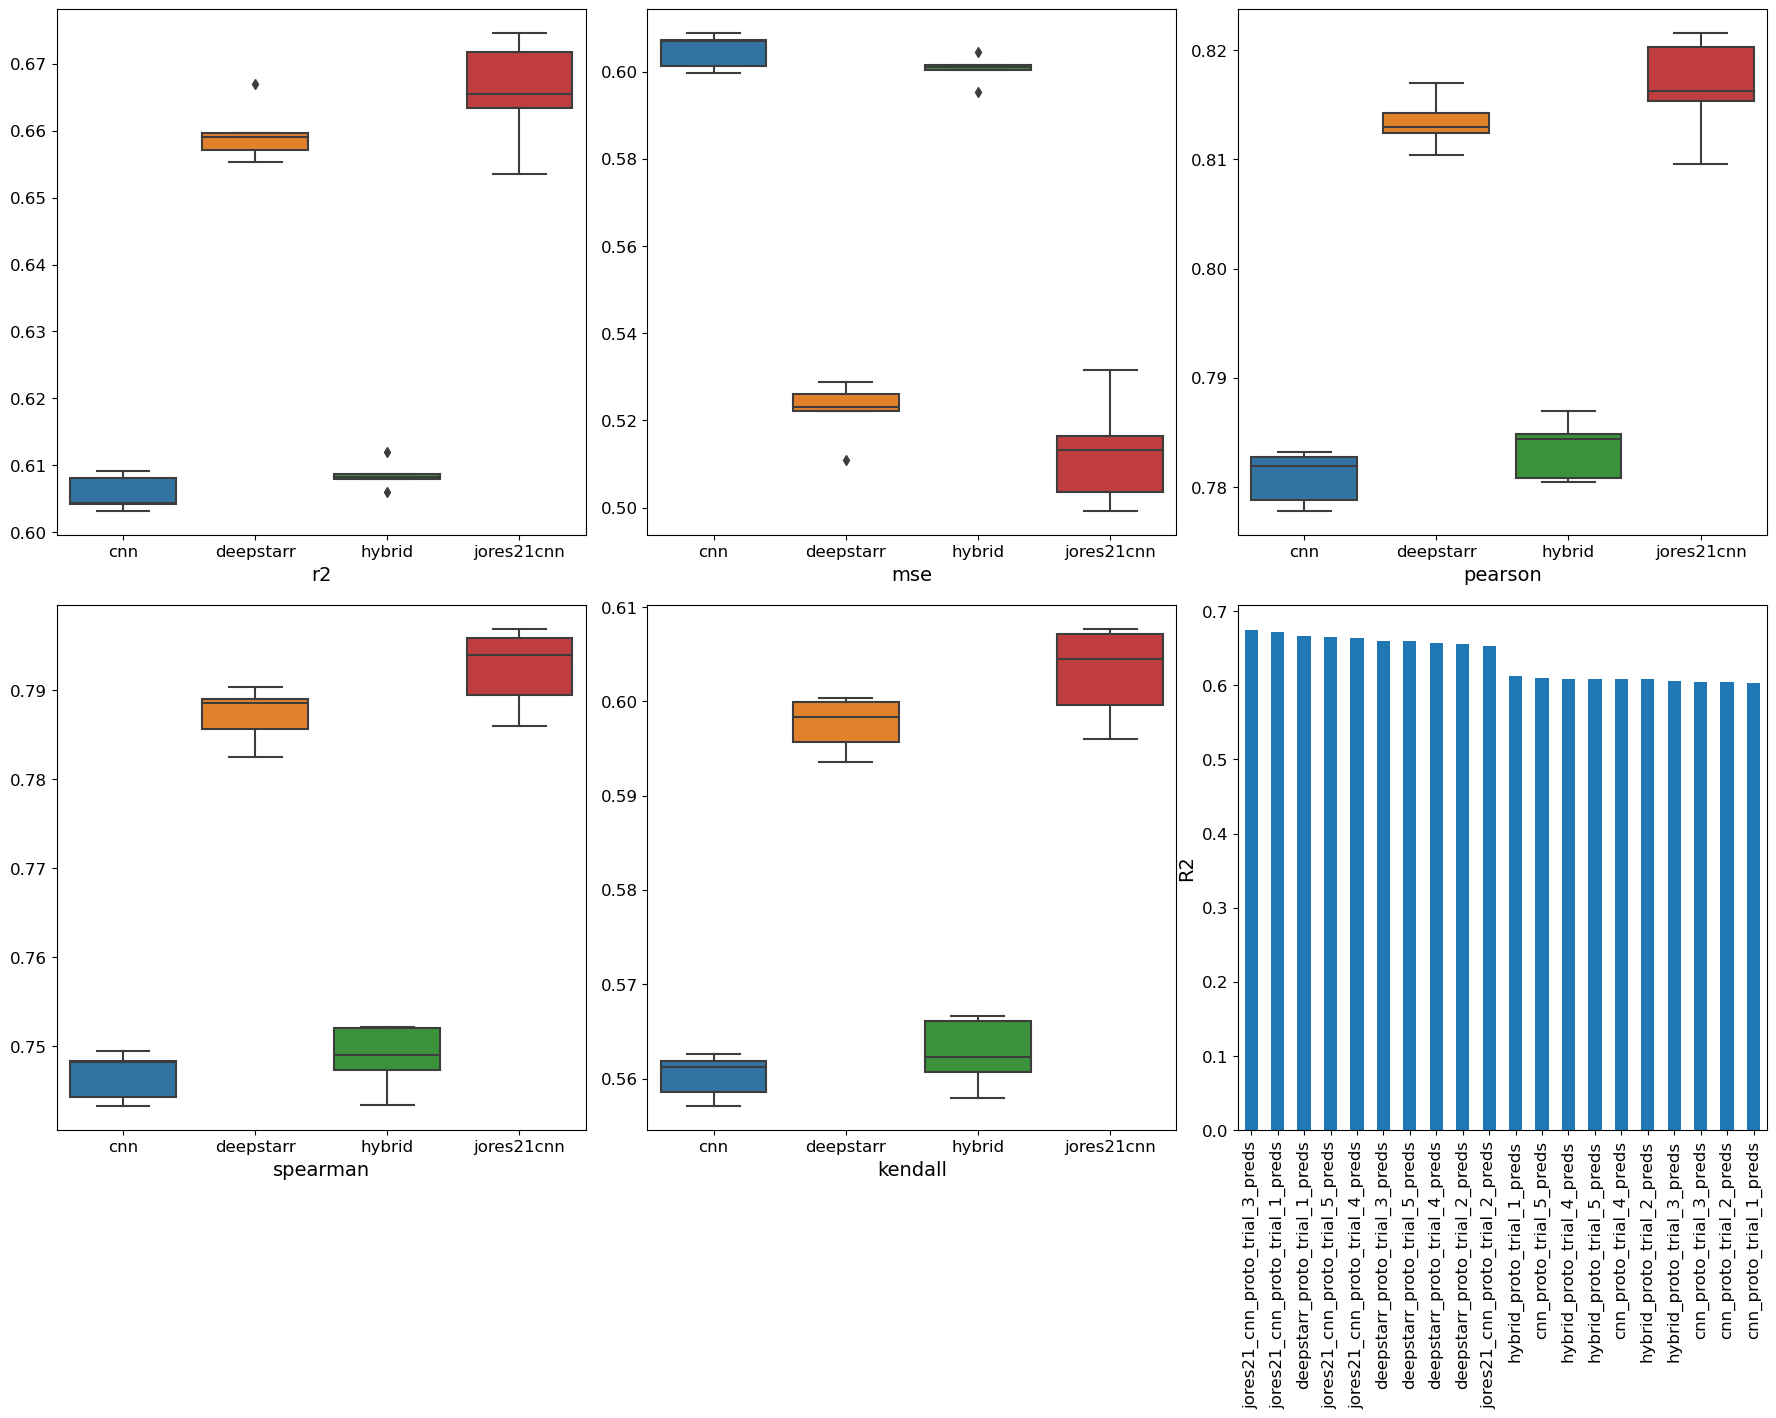

In [20]:
# Summarize performance across models for multiple metrics
proto_model_scores = pl.performance_summary(
    sdata_proto,
    target_key="enrichment",
    prediction_groups=["cnn"]*5 + ["deepstarr"]*5 + ["hybrid"]*5 + ["jores21cnn"]*5,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = proto_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "proto_performance_summary.pdf"))

In [21]:
# Save the performance summary as a table
proto_model_scores.to_csv(os.path.join(settings.output_dir, "proto_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
A 0.5607986833369873 0.6341288416075525 0.7403246368400525
S 0.6075929412957771 0.49240836857875264 0.7524461997999947
Z 0.6890320721479175 0.4349997459348057 0.8162477589766501


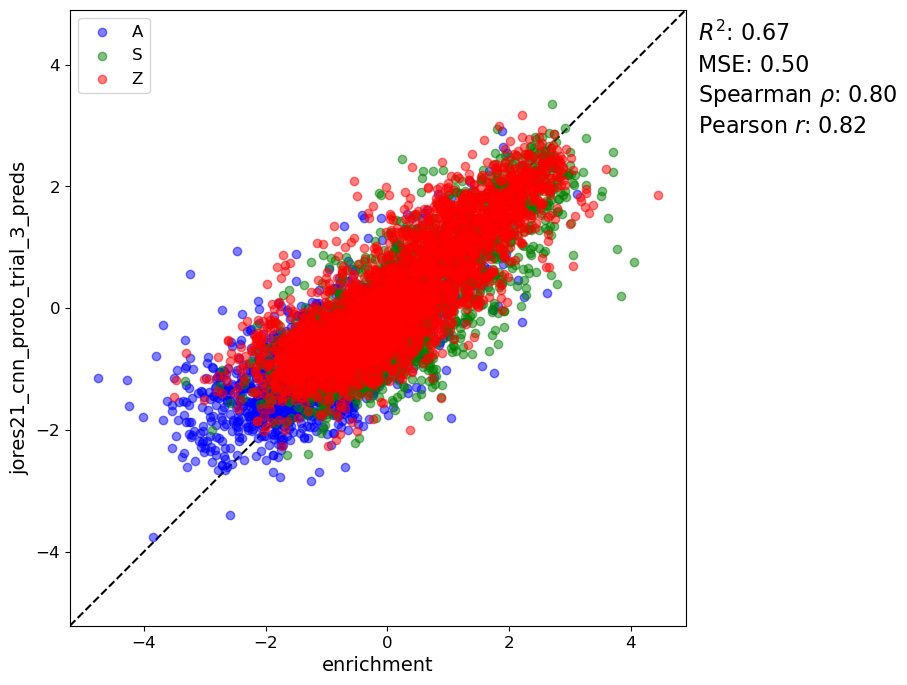

In [22]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_proto, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "proto_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


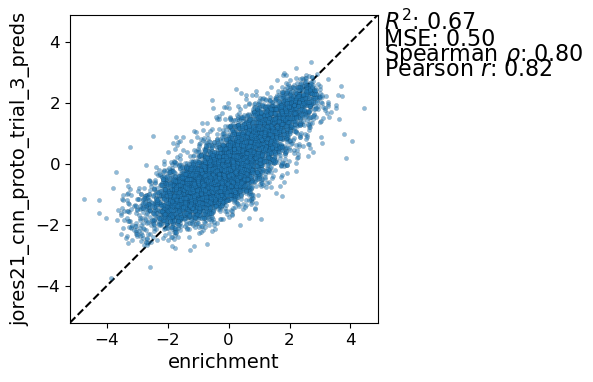

In [23]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_proto, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "proto_best_model_performance_scatter.pdf")
)

## Combined models

In [26]:
# Read in the predictions 
combined_predictions = pd.read_csv(os.path.join(settings.output_dir, "combined", "jores21_combined_test_predictions.tsv"), sep="\t", index_col=0)
#sdata_combined = sd.open_zarr(os.path.join(settings.output_dir, "combined", "jores21_combined_test_predictions.zarr"))
#sdata_combined.load()

In [41]:
sdata_combined = xr.Dataset(combined_predictions.reset_index(),)

In [46]:
sdata_combined = sdata_combined.rename_dims({"dim_0": "_sequence"})

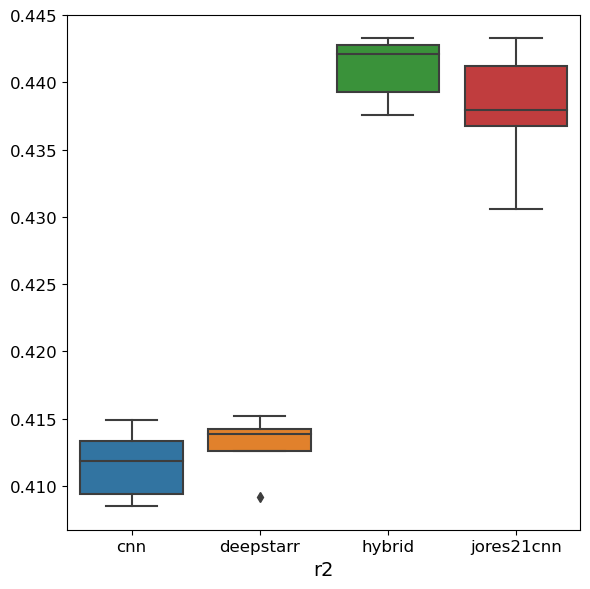

In [33]:
# Summarize performance across models for r2
combined_model_scores = pl.performance_summary(
    sdata_combined,
    target_key="enrichment",
    prediction_groups=["cnn"]*5 + ["deepstarr"]*5 + ["hybrid"]*5 + ["jores21cnn"]*5,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "combined_performance_boxplot.pdf")
)

In [35]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = combined_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([False,  True,  True,  True, False,  True]),
 array([0.42063492, 0.01190476, 0.01190476, 0.01190476, 0.42063492,
        0.01190476]),
 0.008512444610847103,
 0.008333333333333333)

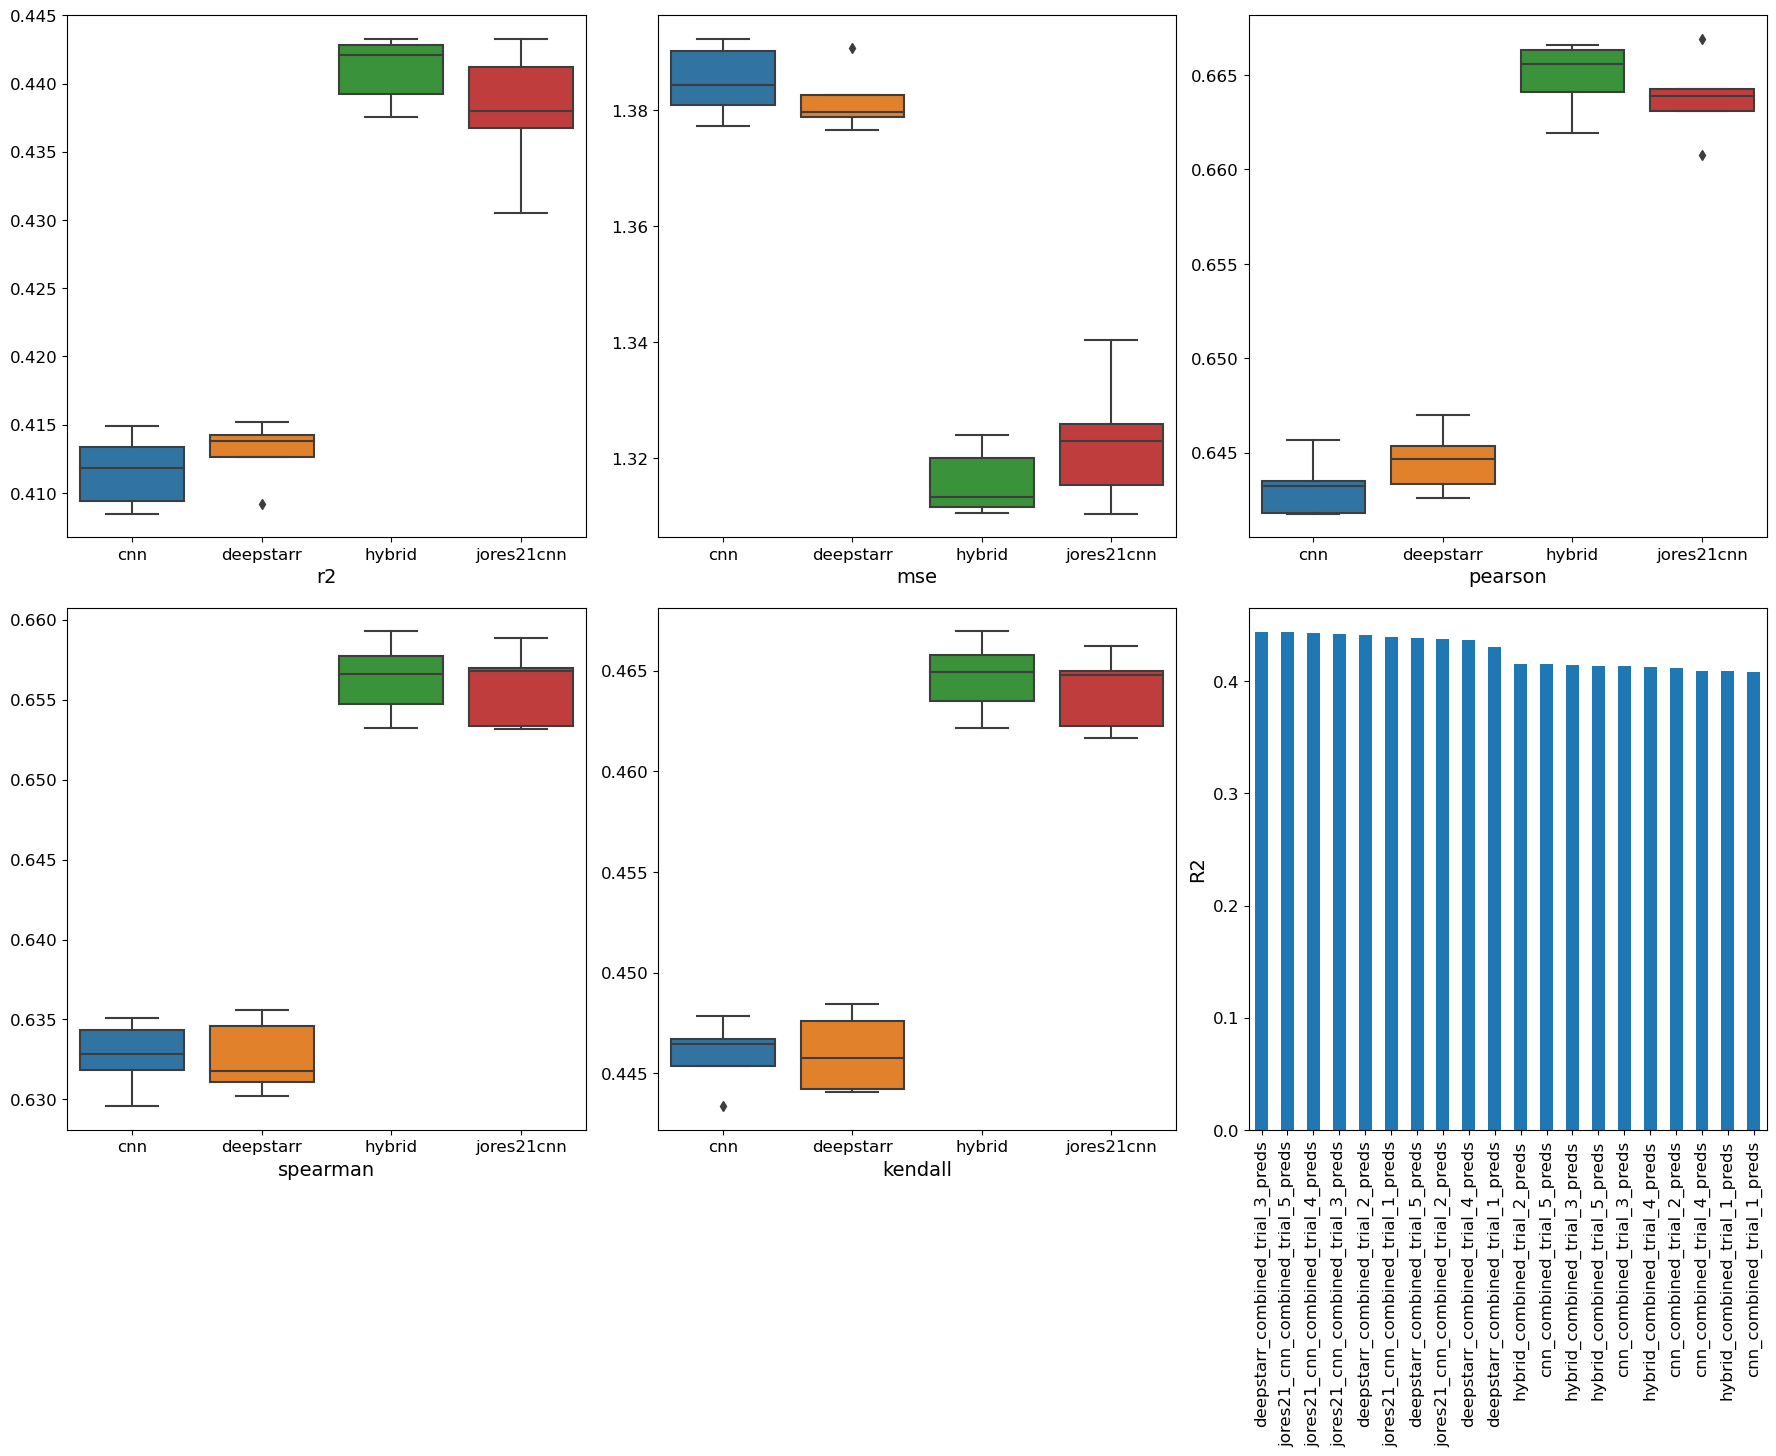

In [36]:
# Summarize performance across models for multiple metrics
combined_model_scores = pl.performance_summary(
    sdata_combined,
    target_key="enrichment",
    prediction_groups=["cnn"]*5 + ["deepstarr"]*5 + ["hybrid"]*5 + ["jores21cnn"]*5,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = combined_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "combined_performance_summary.pdf"))

In [37]:
# Save the performance summary as a table
combined_model_scores.to_csv(os.path.join(settings.output_dir, "combined_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr


KeyError: 'sp'

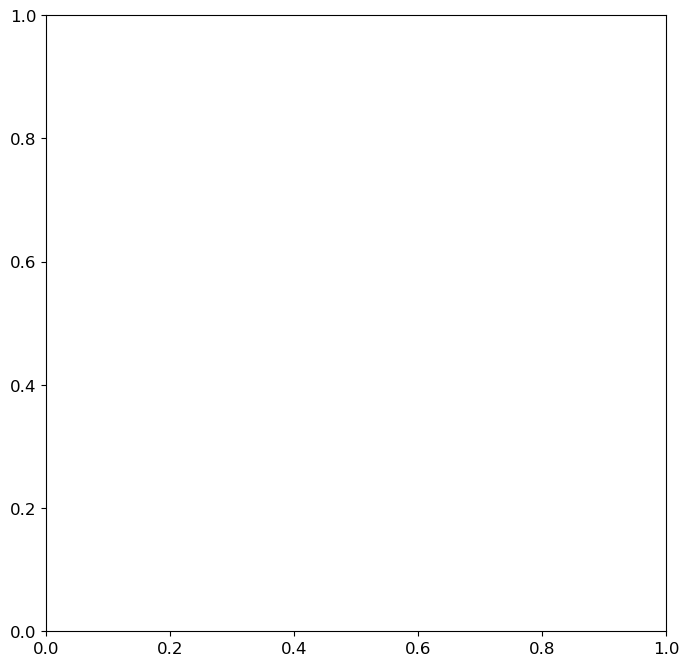

In [47]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_combined, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "combined_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


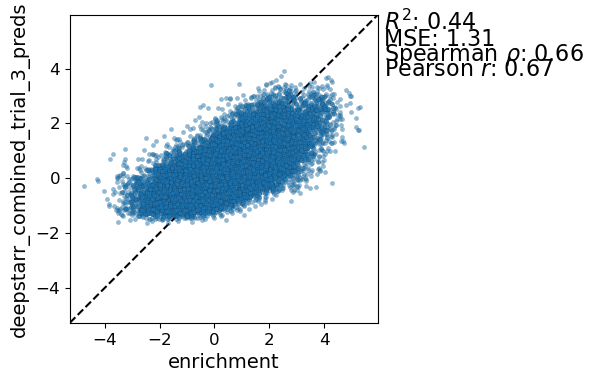

In [48]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_combined, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "csdata_combined_best_model_performance_scatter.pdf")
)

# Performance summary table

In [49]:
# Combined everything into one dataframe
leaf_model_scores["model"] = "leaf"
proto_model_scores["model"] = "proto"
combined_model_scores["model"] = "combined"
merged_model_scores = pd.concat([leaf_model_scores, proto_model_scores, combined_model_scores])
merged_model_scores.to_csv(os.path.join(settings.output_dir, "merged_performance_summary.tsv"), sep="\t")

# Cleaner seq track logos

In [ ]:
# Set-up model
model = "combined"
trial = 3
model_type = "Jores21CNN"

In [ ]:
# Load in importances
sdata_interpretations = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, f"{model}_test_predictions_and_interpretations.h5sd"))

In [ ]:
# Grab the highest predicted seqs for the best model
top5 = sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].sort_values(ascending=False).iloc[:5].index
top5_idx = np.argsort(sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].values)[::-1][:5]

In [ ]:
# Find the ranges in each seq where the model gives high interpretations
seq_num, seq_pos = np.where(np.sum(sdata_interpretations.uns["DeepLift_imps"][top5_idx], axis=1) > 0.2)
ranges = []
for j in range(5):
    curr_pos = seq_pos[np.where(seq_num == j)]
    start = curr_pos[0]
    motifs = []
    for i in range(1, len(curr_pos)):
        if curr_pos[i] - curr_pos[i-1] > 3:
            start = curr_pos[i]
            if curr_pos[i] - start > 4:
                    motifs.append((start, curr_pos[i]))
    if curr_pos[-1] - start > 4:
        motifs.append((start, curr_pos[-1]))
    ranges.append(motifs)

In [ ]:
for i in range(5):
    eu.pl.seq_track(
        sdata_interpretations,
        seq_id=top5[i],
        uns_key="DeepLift_imps",
        ylabel="DeepLift",
        highlights=ranges[i],
        figsize=(8, 1),
        save=os.path.join(eu.settings.figure_dir, f"{model}_best_model_feature_attr_{i+1}.pdf"),
    )

# TomTom annotation analysis

In [ ]:
# Which model?
model = "leaf"
trial = 5
model_type = "ssHybrid"

In [ ]:
# Grab and combine the results from annotating CPEs and TF clusters
tomtom_cpe = pd.read_csv(os.path.join(eu.settings.output_dir, model, f"{model}_best_model_filters_tomtom_CPE.tsv"), sep="\t")
tomtom_tf = pd.read_csv(os.path.join(eu.settings.output_dir, model, f"{model}_best_model_filters_tomtom_TF.tsv"), sep="\t")
tomtom_df = pd.concat([tomtom_cpe, tomtom_tf], axis=0)

In [ ]:
# Save as a dataframe
tomtom_df.to_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom.tsv"), sep="\t")

In [ ]:
# Subset to significant hits
tomtom_sig = tomtom_df[tomtom_df["q-value"] <= 0.05]

In [ ]:
# Add the filter number as a column
tomtom_sig["filter_num"] = tomtom_sig["Query_ID"].str.split("filter").str[-1].astype(int)

In [ ]:
# Separate into filters that were instantiated and those that were purely learned
tomtom_sig_init = tomtom_sig[tomtom_sig["filter_num"] <= 77]
tomtom_sig_learned = tomtom_sig[tomtom_sig["filter_num"] > 77]

In [ ]:
# How many of the original filters returned significant hits?
len(tomtom_sig_init["Target_ID"].unique())

In [ ]:
# Separate the instantiated filters into CPE and TF hits
tomtom_sig_init_tf = tomtom_sig_init[tomtom_sig_init["Target_ID"].str.contains("TF")]
tomtom_sig_init_cpe = tomtom_sig_init[(tomtom_sig_init["Target_ID"].str.contains("TF") == False)]

In [ ]:
# Get the cluster numbers for the TF hits
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["Target_ID"].str.split("_").str[-1]
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["TF_cluster_number"].astype(int)

In [ ]:
# See how many of the initialized TF clusters remained significant to their initialization
(tomtom_sig_init_tf["TF_cluster_number"] + 5 == tomtom_sig_init_tf["filter_num"]).sum()

In [ ]:
# Generate a naming map for plotting
core_promoter_elements = eu.dl.motif.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'CPEs.meme'))
tf_groups = eu.dl.motif.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'TF-clusters.meme'))
all_motifs = {**core_promoter_elements.motifs, **tf_groups.motifs}
id_map = {}
for id_name, motif in all_motifs.items():
    id_map[id_name] = motif.name

In [ ]:
# Plot the frequencies of hits to motifs in the learned filters
plt.figure(figsize=(6, 3), dpi=300)
tomtom_sig_learned["Target_ID"].map(id_map).value_counts().plot(kind="bar", ylabel="Number of filters")
plt.savefig(os.path.join(eu.settings.figure_dir, f"{model}_best_model_filters_tomtom_barplot.pdf"))

In [ ]:
# Get the most significant hits to each motif
top_tomtom_sig_learned = tomtom_sig_learned.sort_values("q-value").groupby("Target_ID").head(1)
top_tomtom_sig_learned.to_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom_top_hits.tsv"), sep="\t")

In [ ]:
# Save as a dataframe
merged_df = pd.DataFrame()
for model in ["leaf", "proto", "combined"]:
    x = pd.read_csv(os.path.join(eu.settings.output_dir, model, f"{model}_best_model_filters_tomtom.tsv"), sep="\t", comment="#", index_col=0)
    x["system"] = model
    merged_df = pd.concat([merged_df, x])

In [ ]:
merged_df = merged_df[~merged_df["Query_ID"].isna()]

In [ ]:
merged_df.to_csv(os.path.join(eu.settings.output_dir, "best_models_filters_tomtom.tsv"), sep="\t", index=False)

# Loss curve

In [ ]:
# Which model?
model = "combined"
trial = 3
model_type = "Jores21CNN"

In [ ]:
# Plot and save the training and metric curves
eu.pl.training_summary(
    os.path.join(eu.settings.logging_dir, model_type, f"{model}_trial_{trial}"),
    metric="r2",
    save=os.path.join(eu.settings.figure_dir, f"{model}_best_model_training_summary.pdf")
)

---

In [ ]:
best_model = models.SequenceModule.load_from_checkpoint(
    "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21/jores21_cnn/0.0.1/checkpoints/epoch=15-step=7328.ckpt",
    arch=model.arch,
)

In [ ]:
sdata_leaf_test = sd.open_zarr(os.path.join(settings.dataset_dir, "jores21_leaf_test.zarr"))

In [ ]:
val_mask = np.where(~sdata_leaf["train_val"])[0]
sdata_leaf_val = sdata_leaf.isel(_sequence=val_mask)
sdata_leaf_val

<xarray.Dataset>
Dimensions:     (_sequence: 6501, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 0.5687 1.834 -2.684 ... -2.51 -2.378 0.1162
    gene        (_sequence) <U1 dask.array<chunksize=(6501,), meta=np.ndarray>
    id          (_sequence) <U8 dask.array<chunksize=(6501,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 0 1 0 1 0 0 ... 0 1 0 0 1 0 0
    seq         (_sequence) <U1 dask.array<chunksize=(6501,), meta=np.ndarray>
    set         (_sequence) <U1 dask.array<chunksize=(6501,), meta=np.ndarray>
    sp          (_sequence) <U1 dask.array<chunksize=(6501,), meta=np.ndarray>
    train_val   (_sequence) bool False False False False ... False False False
    target      (_sequence) float64 0.5687 1.834 -2.684 ... -2.51 -2.378 0.1162
    nan_mask    (_sequence) bool False False False False ... False False False
Attributes:
    max_jitter:  0

In [ ]:
test_ohe_seq = sdata_leaf_test["ohe_seq"].to_numpy().transpose(0, 2, 1)

In [ ]:
val_ohe_seq = sdata_leaf_val["ohe_seq"].to_numpy().transpose(0, 2, 1)

In [ ]:
val_preds = best_model.predict(val_ohe_seq)

Predicting on batches:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
best_model.eval()

SequenceModule(
  (arch): Jores21CNN(
    (biconv): BiConv1DTower(
      (kernels): ParameterList(
          (0): Parameter containing: [torch.float32 of size 256x4x13]
          (1): Parameter containing: [torch.float32 of size 256x256x13]
          (2): Parameter containing: [torch.float32 of size 256x256x13]
      )
      (biases): ParameterList(
          (0): Parameter containing: [torch.float32 of size 256]
          (1): Parameter containing: [torch.float32 of size 256]
          (2): Parameter containing: [torch.float32 of size 256]
      )
    )
    (conv): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=same)
    (dropout): Dropout(p=0.3, inplace=False)
    (fc): Linear(in_features=43520, out_features=64, bias=True)
    (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
  )
  (train_metric): R2Score()
  (val_metric): R2Score()
  (test_metric): R2Score()
)

In [ ]:
val_preds_np = val_preds.numpy().squeeze()

In [ ]:
val_trues_np = sdata_leaf_val["enrichment"].to_numpy()

In [ ]:
model.val_metric(val_preds.squeeze(), torch.tensor(val_trues_np))

tensor(0.6857)

In [ ]:
pearsonr(val_trues_np, val_preds_np)[0]**2

0.6862161176804705

In [ ]:
r2_score(val_trues_np, val_preds_np)

0.6857098078286796

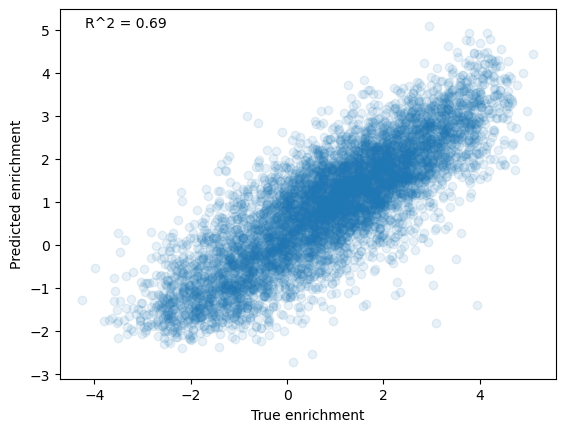

In [ ]:
# Plot a scatter plot and include the R^2
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.scatter(val_trues_np, val_preds_np, alpha=0.1)
plt.xlabel("True enrichment")
plt.ylabel("Predicted enrichment")
plt.annotate(f"R^2 = {r2_score(val_trues_np, val_preds_np):.2f}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

In [ ]:
preds = best_model.predict(test_ohe_seq)

Predicting on batches:   0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
preds_np = preds.numpy().squeeze()

In [ ]:
trues_np = sdata_leaf_test["enrichment"].to_numpy()

In [ ]:
r2_score(trues_np, preds_np)

0.6810278176410661

In [ ]:
pearsonr(trues_np, preds_np)[0]

0.8253454506005374

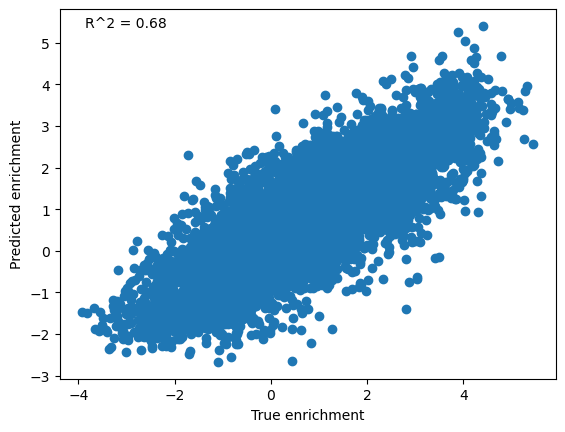

In [ ]:
# Plot a scatter plot and include the R^2
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.scatter(trues_np, preds_np)
plt.xlabel("True enrichment")
plt.ylabel("Predicted enrichment")
plt.annotate(f"R^2 = {r2_score(trues_np, preds_np):.2f}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()
